<a href="https://colab.research.google.com/github/emilyclifton/cs5262-p2/blob/main/week11/assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 10
### _Emily Clifton_
### _CS5262_

# Neural Network In Pytorch
This assignment aims to get familiarized with building the whole pipeline of deep learning in Pytorch to perform classification and test it out on the CIFAR-10 dataset. All the code will be implemented in this notebook.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/Colab\ Notebooks/HW3_Full

/content/gdrive/MyDrive/Colab Notebooks/HW3_Full


First, let's install modules not already installed by Google Colab.

In [3]:
! pip install torch_utils

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [4]:
# Data utils from data_util.py
from __future__ import print_function

from six.moves import cPickle as pickle
import numpy as np
import os
# from scipy.misc import imread
import imageio
import platform

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return pickle.load(f)
    elif version[0] == '3':
        return pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))


def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        if (mt == 'bmodel'):
          X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        else:
          X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

def load_tiny_imagenet(path, dtype=np.float32, subtract_mean=True):
    """
  Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
  TinyImageNet-200 have the same directory structure, so this can be used
  to load any of them.

  Inputs:
  - path: String giving path to the directory to load.
  - dtype: numpy datatype used to load the data.
  - subtract_mean: Whether to subtract the mean training image.

  Returns: A dictionary with the following entries:
  - class_names: A list where class_names[i] is a list of strings giving the
    WordNet names for class i in the loaded dataset.
  - X_train: (N_tr, 3, 64, 64) array of training images
  - y_train: (N_tr,) array of training labels
  - X_val: (N_val, 3, 64, 64) array of validation images
  - y_val: (N_val,) array of validation labels
  - X_test: (N_test, 3, 64, 64) array of testing images.
  - y_test: (N_test,) array of test labels; if test labels are not available
    (such as in student code) then y_test will be None.
  - mean_image: (3, 64, 64) array giving mean training image
  """
    # First load wnids
    with open(os.path.join(path, 'wnids.txt'), 'r') as f:
        wnids = [x.strip() for x in f]

    # Map wnids to integer labels
    wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

    # Use words.txt to get names for each class
    with open(os.path.join(path, 'words.txt'), 'r') as f:
        wnid_to_words = dict(line.split('\t') for line in f)
        for wnid, words in wnid_to_words.iteritems():
            wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
    class_names = [wnid_to_words[wnid] for wnid in wnids]

    # Next load training data.
    X_train = []
    y_train = []
    for i, wnid in enumerate(wnids):
        if (i + 1) % 20 == 0:
            print('loading training data for synset %d / %d' % (i + 1, len(wnids)))
        # To figure out the filenames we need to open the boxes file
        boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
        with open(boxes_file, 'r') as f:
            filenames = [x.split('\t')[0] for x in f]
        num_images = len(filenames)

        X_train_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)
        y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
        for j, img_file in enumerate(filenames):
            img_file = os.path.join(path, 'train', wnid, 'images', img_file)
            img = imageio.imread(img_file)
            if img.ndim == 2:
                ## grayscale file
                img.shape = (64, 64, 1)
            X_train_block[j] = img.transpose(2, 0, 1)
        X_train.append(X_train_block)
        y_train.append(y_train_block)

    # We need to concatenate all training data
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # Next load validation data
    with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
        img_files = []
        val_wnids = []
        for line in f:
            img_file, wnid = line.split('\t')[:2]
            img_files.append(img_file)
            val_wnids.append(wnid)
        num_val = len(img_files)
        y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
        X_val = np.zeros((num_val, 3, 64, 64), dtype=dtype)
        for i, img_file in enumerate(img_files):
            img_file = os.path.join(path, 'val', 'images', img_file)
            img = imageio.imread(img_file)
            if img.ndim == 2:
                img.shape = (64, 64, 1)
            X_val[i] = img.transpose(2, 0, 1)

    # Next load test images
    # Students won't have test labels, so we need to iterate over files in the
    # images directory.
    img_files = os.listdir(os.path.join(path, 'test', 'images'))
    X_test = np.zeros((len(img_files), 3, 64, 64), dtype=dtype)
    for i, img_file in enumerate(img_files):
        img_file = os.path.join(path, 'test', 'images', img_file)
        img = imageio.imread(img_file)
        if img.ndim == 2:
            img.shape = (64, 64, 1)
        X_test[i] = img.transpose(2, 0, 1)

    y_test = None
    y_test_file = os.path.join(path, 'test', 'test_annotations.txt')
    if os.path.isfile(y_test_file):
        with open(y_test_file, 'r') as f:
            img_file_to_wnid = {}
            for line in f:
                line = line.split('\t')
                img_file_to_wnid[line[0]] = line[1]
        y_test = [wnid_to_label[img_file_to_wnid[img_file]] for img_file in img_files]
        y_test = np.array(y_test)

    mean_image = X_train.mean(axis=0)
    if subtract_mean:
        X_train -= mean_image[None]
        X_val -= mean_image[None]
        X_test -= mean_image[None]

    return {
        'class_names': class_names,
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
        'class_names': class_names,
        'mean_image': mean_image,
    }


def load_models(models_dir):
    """
  Load saved models from disk. This will attempt to unpickle all files in a
  directory; any files that give errors on unpickling (such as README.txt) will
  be skipped.

  Inputs:
  - models_dir: String giving the path to a directory containing model files.
    Each model file is a pickled dictionary with a 'model' field.

  Returns:
  A dictionary mapping model file names to models.
  """
    models = {}
    for model_file in os.listdir(models_dir):
        with open(os.path.join(models_dir, model_file), 'rb') as f:
            try:
                models[model_file] = load_pickle(f)['model']
            except pickle.UnpicklingError:
                continue
    return models


## Task 1: Design the Neural Network and Data Preparation


In the beginning, please import all the packages you need. We provide some packages here, which might be helpful when you build your code.

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, sampler
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf


from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch import optim, cuda, Tensor
import tqdm

# Data science tools
import numpy as np

import os

# Image manipulations
from PIL import Image
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
#plt.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

###Network Design
Then, we need to define a class for your network. The network should include two linear layer, one Relu layer, and one dropout layer.

In [6]:
# define model
class bmodel(nn.Module):
    def __init__(self, input_d, hidden_d, output_d, dropout=0.2):
        super().__init__()
        # Define all the layers that you need in your network
        # You can use nn.Linear() to define the linear layer
        # You can use nn.Dropout() to define the dropout layer
        # You can use F.relu() to define your ReLu layer
        ######################
        ### YOUR CODE HERE ###
        ######################
        self.linear1 = nn.Linear(input_d, hidden_d)
        self.linear2 = nn.Linear(hidden_d, output_d)
        self.dropout = nn.Dropout(dropout)
        ######################
        ### YOUR CODE END  ###
        ######################

    def forward(self, x):
        # Design your network structure here
        ######################
        ### YOUR CODE HERE ###
        ######################
        # Pass input through the first linear layer, then through ReLU
        x = self.linear1(x)
        x = F.relu(x)
        # Apply dropout after the activation function
        x = self.dropout(x)
        # Pass the result through the second linear layer
        x = self.linear2(x)
        return x
        ######################
        ### YOUR CODE END  ###
        ######################


Now, we can design our toy model to test your network.

In [7]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return bmodel(input_size, hidden_size, num_classes)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

toy_model = init_toy_model()
train_X, train_Y = init_toy_data()
validation_X, validation_Y = init_toy_data()

Cuda is Compute Unified Device Architecture, which can achieve parallel computing. It will improve our learning speed in the parameter update by using GPU rather than CPU.

In [8]:
# Check whether there is a gpu for cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)

Train on gpu: True
1 gpus detected.
True False


###Data Preparation
Next, we need to organize the data before we load them into the network. In Pytorch, we use Tensor as the data structure for computing, and we use "dataloaders" to achieve mini-batch from the whole dataset.

In [9]:
# Datasets organization
batch_size = 1

# Transfer the data from numpy to tensor
data = {
    'train':
    TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).float()),
    'valid':
    # please define your validation dataset
    ######################
    ### YOUR CODE HERE ###
    ######################
    TensorDataset(torch.from_numpy(validation_X).float(), torch.from_numpy(validation_Y).float())
    ######################
    ### YOUR CODE END  ###
    ######################

}


# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'valid':
    # please define your validation data loader
    ######################
    ### YOUR CODE HERE ###
    ######################
    DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=10)
    ######################
    ### YOUR CODE END ####
    ######################
}



# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([1, 4]), torch.Size([1]))

### Setting Learning Parameters
In our training process, we need to set up the loss function and optimizer tool.

In [10]:
# Set up your criterion and optimizer
# You can use nn.CrossEntropyLoss() and optim.Adam()
#####################
### YOUR CODE HERE###
#####################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(toy_model.parameters(), lr=0.001)
#####################
### YOUR CODE END ###
#####################

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([10, 4])
torch.Size([10])
torch.Size([3, 10])
torch.Size([3])


## Task 2: Build the Training Pipeline

### Training Process
We are now defining the train function. Please follow the instruction to finish each part.

In [11]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=10,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()

        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):

            # Tensors to gpu, both model parameters, data, and target need to be tensors.
            # You can use .cuda() function
            ######################
            ### YOUR CODE HERE ###
            ######################
            data, target = data.to(device), target.to(device)
            ######################
            ### YOUR CODE END  ###
            ######################

            # Clear gradients
            optimizer.zero_grad()

            # Forward path
            ######################
            ### YOUR CODE HERE ###
            ######################
            output = model(data)
            ######################
            ### YOUR CODE END  ###
            ######################

            # Loss function
            ######################
            ### YOUR CODE HERE ###
            ######################
            target = target.long()
            loss = criterion(output, target)
            ######################
            ### YOUR CODE END  ###
            ######################

            # Backward path (backpropagation)
            ######################
            ### YOUR CODE HERE ###
            ######################
            loss.backward()
            ######################
            ### YOUR CODE END  ###
            ######################

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))

            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    data, target = data.to(device), target.to(device)
                    ######################
                    ### YOUR CODE END  ###
                    ######################

                    # Forward path
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    output = model(data)
                    ######################
                    ### YOUR CODE END  ###
                    ######################

                    # Validation loss computation
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    target = target.long()
                    loss = criterion(output, target)
                    ######################
                    ### YOUR CODE END  ###
                    ######################

                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))

                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)


                # Calculate average losses and Calculate average accuracy
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    # You can use torch.save()
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    torch.save(model.state_dict(), save_file_name)
                    ######################
                    ### YOUR CODE END  ###
                    ######################

                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        # You can use model.load_state_dict()
                        ######################
                        ### YOUR CODE HERE ###
                        ######################
                        model.load_state_dict(torch.load(save_file_name))
                        ######################
                        ### YOUR CODE END  ###
                        ######################

                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

## Task 3: Train the network

### Train a Network With Toy Data


Well done! Once we finish our train process design, we can start to train our network with our toy dataset.

In [12]:
from timeit import default_timer as timer
save_file_name = f'toy_model_best_model.pt'
train_on_gpu = cuda.is_available()

model, history = train(toy_model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=500,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.6305 	Validation Loss: 2.0327
		Training Accuracy: 40.00%	 Validation Accuracy: 20.00%

Epoch: 1 	Training Loss: 1.9250 	Validation Loss: 1.9584
		Training Accuracy: 20.00%	 Validation Accuracy: 20.00%

Epoch: 2 	Training Loss: 2.2239 	Validation Loss: 1.8897
		Training Accuracy: 20.00%	 Validation Accuracy: 20.00%

Epoch: 3 	Training Loss: 2.1438 	Validation Loss: 1.8074
		Training Accuracy: 20.00%	 Validation Accuracy: 20.00%

Epoch: 4 	Training Loss: 1.9753 	Validation Loss: 1.7323
		Training Accuracy: 20.00%	 Validation Accuracy: 20.00%

Epoch: 5 	Training Loss: 1.7228 	Validation Loss: 1.6585
		Training Accuracy: 40.00%	 Validation Accuracy: 20.00%

Epoch: 6 	Training Loss: 1.6751 	Validation Loss: 1.5927
		Training Accuracy: 0.00%	 Validation Accuracy: 20.00%

Epoch: 7 	Training Loss: 1.2497 	Validation Loss: 1.5333
		Training Accuracy: 40.00%	 Validation Accuracy: 20.00%

Epoch: 8 	Training Loss: 1.7613 	Validation Los

Now, we can check the losses and accuracy during the training.

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

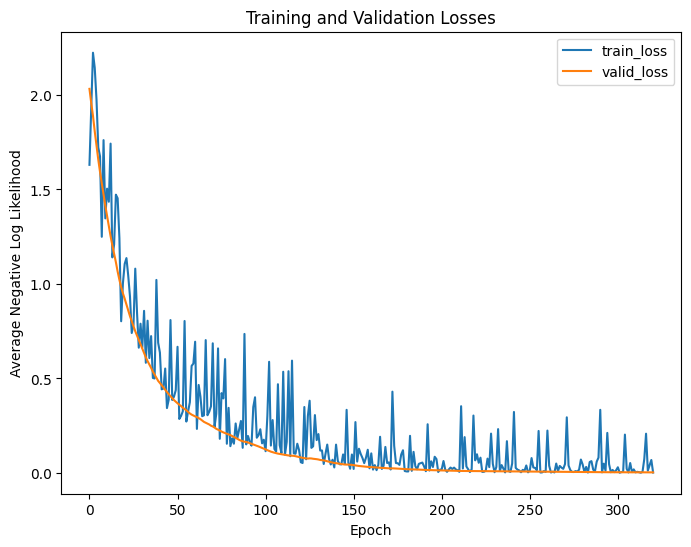

In [13]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

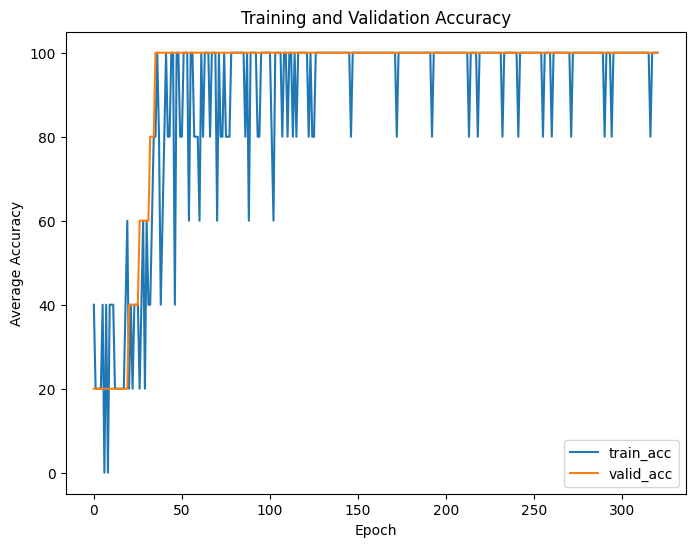

In [14]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

### Train a Network With Cifar-10 Data
Now we may use the cifar-10 dataset to train our model. First, we will load the cifar-10 dataset.

In [15]:
%cd datasets

/content/gdrive/MyDrive/Colab Notebooks/HW3_Full/datasets


In [16]:
mt = 'bmodel'

In [17]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '.'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
train_X, train_Y, validation_X, validation_Y, test_X, test_Y = get_CIFAR10_data()
print('Train data shape: ', train_X.shape)
print('Train labels shape: ', train_Y.shape)
print('Validation data shape: ', validation_X.shape)
print('Validation labels shape: ', validation_Y.shape)
print('Test data shape: ', test_X.shape)
print('Test labels shape: ', test_Y.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


Since Cifar-10 has a larger size of data, which is harder to train, we need to increase our network parameters to solve this task.


In [18]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10

model = bmodel(input_size, hidden_size, num_classes)

Use the same chunk above to organize our new data. Now we may need a bigger batch_size for training.

In [19]:
# Datasets from folders
batch_size = 16
# Transfer the data from numpy to tensor
data = {
    'train':
    TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).float()),
    'valid':
    ######################
    ### YOUR CODE HERE ###
    ######################
    TensorDataset(torch.from_numpy(validation_X).float(), torch.from_numpy(validation_Y).float()),
    #####################
    ### YOUR CODE END ###
    #####################

}


# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'valid':
    ######################
    ### YOUR CODE HERE ###
    ######################
    DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=10),
    ######################
    ### YOUR CODE END ###
    ######################
}


# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([16, 3072]), torch.Size([16]))

Set up our criterion and optimizer for the new model.

In [20]:
# Set up your criterion and optimizer
######################
### YOUR CODE HERE ###
######################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#####################
### YOUR CODE END ###
#####################

Train your new network and get the results. At this time, the training process may need more time.

In [21]:
from timeit import default_timer as timer
save_file_name = f'cifar_model_best_model.pt'
train_on_gpu = cuda.is_available()

model, history = train(model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=500,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 8.1024 	Validation Loss: 2.1720
		Training Accuracy: 27.64%	 Validation Accuracy: 30.80%

Epoch: 1 	Training Loss: 3.0436 	Validation Loss: 3.1773
		Training Accuracy: 23.66%	 Validation Accuracy: 27.00%

Epoch: 2 	Training Loss: 3.6165 	Validation Loss: 3.3234
		Training Accuracy: 22.54%	 Validation Accuracy: 20.30%

Epoch: 3 	Training Loss: 3.7228 	Validation Loss: 3.3993
		Training Accuracy: 22.38%	 Validation Accuracy: 24.10%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 2.17 and acc: 24.10%
49.79 total seconds elapsed. 12.45 seconds per epoch.


It seems that the process will end very early since there is no progress during the training. Let's print the results.

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

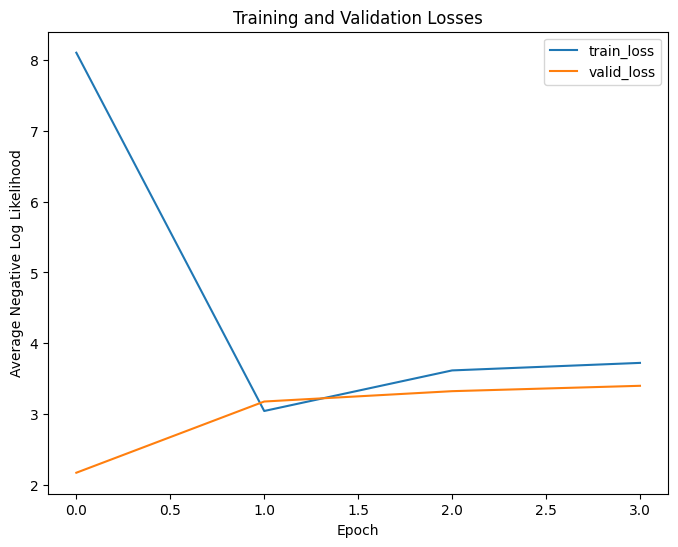

In [22]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

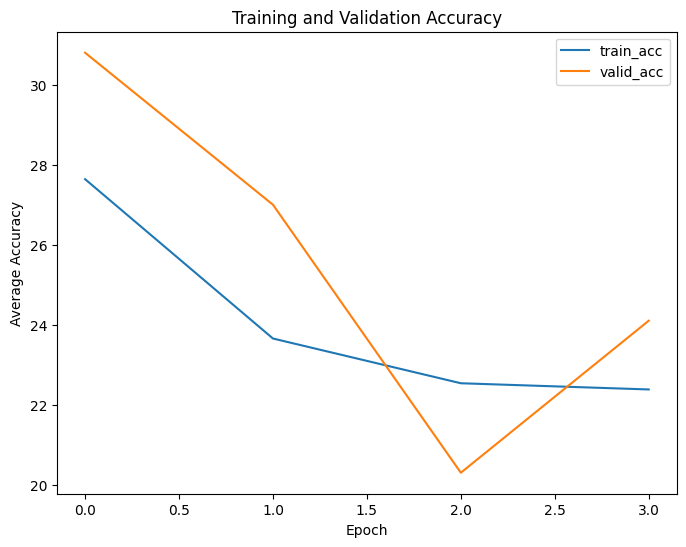

In [23]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

##Task 4: Improve The Performance
As we have known in HW2, a two-layer-network can not get a good performance. Here, we may (1) add more layers to make the network deeper, or (2) replace your bmodel() with networks provided by PyTorch. https://pytorch.org/vision/0.8/models.html
You just need to do one of these two options.

You can reuse the code you have from Task 2 and 3

In [ ]:
######################
### YOUR CODE HERE ###
######################

I will implement ResNet18 fro CIFAR-10 classification. ResNet18 provides a robust architecture that is able to handle deeper networks through residual connections, mitigating the vanishing gradient problem. I had to adapt the model to CIFAR-10's image size and number of classes, ensuring the final fully connected lay outputs 10 classes. I also integrated a learning rate scheduler and early stopping in out training process to enhance model training and prevent overfitting

In [24]:
from torchvision.models import resnet18, ResNet18_Weights

In [96]:
def train2(model,
           criterion,
           optimizer,
           train_loader,
           valid_loader,
           save_file_name,
           max_epochs_stop=3,
           n_epochs=10,
           print_every=1,
           scheduler=None):
    """Train a PyTorch Model 2

     Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Initialization
    epochs_no_improve = 0
    valid_loss_min = np.inf

    valid_best_acc = 0
    history = []

    # GPU available?
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    overall_start = timer()

    best_epoch = 0

    # Main loop
    for epoch in range(n_epochs):

        # Set to training
        model.train()

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        train_acc = 0.0

        for data, target in train_loader:
            # target = target.type(torch.LongTensor)
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            output = model(data)
            loss = criterion(output, target.long())
            loss.backward()

            optimizer.step()

            train_loss += loss.item() * data.size(0)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            for data, target in valid_loader:
                # target = target.type(torch.LongTensor)
                data, target = data.to(device), target.to(device)

                output = model(data)
                loss = criterion(output, target)

                valid_loss += loss.item() * data.size(0)

                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

                valid_acc += accuracy.item() * data.size(0)

        # Calculate average losses and accuracy
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)
        train_acc = train_acc / len(train_loader.dataset)
        valid_acc = valid_acc / len(valid_loader.dataset)
        history.append([train_loss, valid_loss, train_acc, valid_acc])

        # Print training and validation results
        if (epoch + 1) % print_every == 0:
            print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
            print(f'\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_file_name)
            epochs_no_improve = 0
            valid_loss_min = valid_loss
            best_epoch = epoch
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= max_epochs_stop:
                print(f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
                break

        # Step the scheduler after each epoch
        if scheduler:
            scheduler.step()

    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%')
    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [44]:
mt = 'resnet18'

In [104]:
def get_CIFAR10_data2(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '.'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]


    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test

In [111]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   del criterion, optimizer
   del model
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
train_X, train_Y, validation_X, validation_Y, test_X, test_Y = get_CIFAR10_data2()
print('Train data shape: ', train_X.shape)
print('Train labels shape: ', train_Y.shape)
print('Validation data shape: ', validation_X.shape)
print('Validation labels shape: ', validation_Y.shape)
print('Test data shape: ', test_X.shape)
print('Test labels shape: ', test_Y.shape)

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)


In [116]:
batch_size = 64

# Load the datasets with the transformations
train_dataset = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).long())
valid_dataset = TensorDataset(torch.from_numpy(validation_X).float(), torch.from_numpy(validation_Y).long())


# Modify the final fully connected layer to match the number of classes (10 for CIFAR-10)
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

from timeit import default_timer as timer
save_file_name = f'cifar_model_best_model.pt'
train_on_gpu = cuda.is_available()

# Create the DataLoader objects
dataloaders2 = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    'valid': DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
}

model, history = train2(model,
    criterion,
    optimizer,
    dataloaders2['train'],
    dataloaders2['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=25,
    n_epochs=500,
    print_every=1,
    scheduler=scheduler)


Epoch: 0 	Training Loss: 2.2121 	Validation Loss: 1.8654
	Training Accuracy: 27.77%	 Validation Accuracy: 34.80%

Epoch: 1 	Training Loss: 1.6072 	Validation Loss: 1.6620
	Training Accuracy: 40.59%	 Validation Accuracy: 42.60%

Epoch: 2 	Training Loss: 1.4999 	Validation Loss: 1.7176
	Training Accuracy: 45.07%	 Validation Accuracy: 40.90%

Epoch: 3 	Training Loss: 1.4352 	Validation Loss: 1.4907
	Training Accuracy: 47.47%	 Validation Accuracy: 45.80%

Epoch: 4 	Training Loss: 1.4058 	Validation Loss: 1.6546
	Training Accuracy: 49.00%	 Validation Accuracy: 43.50%

Epoch: 5 	Training Loss: 1.3905 	Validation Loss: 1.4443
	Training Accuracy: 49.54%	 Validation Accuracy: 48.90%

Epoch: 6 	Training Loss: 1.3824 	Validation Loss: 1.3222
	Training Accuracy: 50.47%	 Validation Accuracy: 51.70%

Epoch: 7 	Training Loss: 1.3661 	Validation Loss: 1.7245
	Training Accuracy: 50.80%	 Validation Accuracy: 42.30%

Epoch: 8 	Training Loss: 1.3509 	Validation Loss: 1.6279
	Training Accuracy: 51.67%	 Va

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

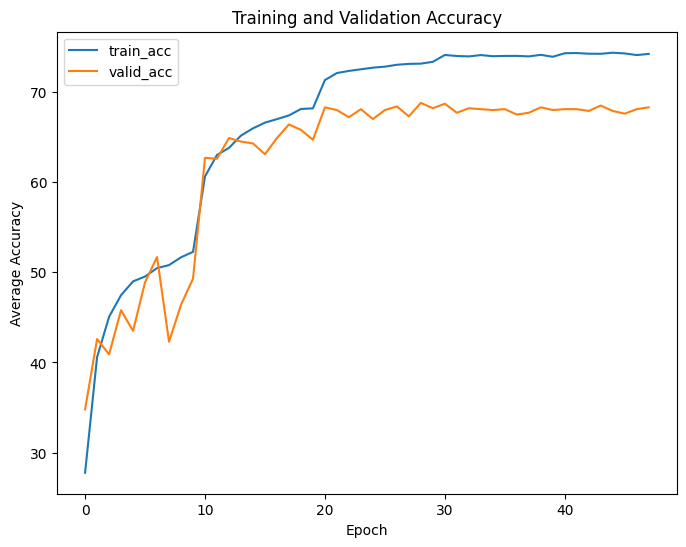

In [117]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

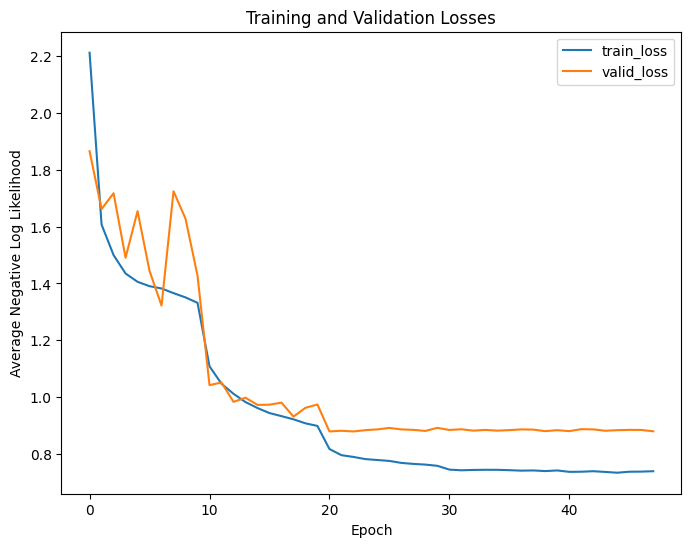

In [118]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

In [ ]:
#####################
### YOUR CODE END ###
#####################